<a id="A"></a>
# <div style="text-align:center; border-radius:15px 15px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#56008c; overflow:hidden"><b> Sentiment Analysis-NLP  </b></div>

<div style="text-align: center;">
    <img src="https://i0.wp.com/pixarpost.com/wp-content/uploads/2024/04/Inside-Out-2-Concept-Art-Color-Lineup-Rona-Liu.jpg?fit=1920%2C870&ssl=1" alt="alzheimers" style="width:100%; height:auto; border-radius: 30px;">
</div>

<h2>Summary 📝</h2>
<div style="padding: 20px; border-color: #c77220; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid purple;">
     <ul style="font-size: 16px; font-family: 'Arial'; line-height: 1.5em;">
        <li>In this notebook, I will analyze a dataset containing text attributes and emotion targets. Using a machine learning algorithm called Random Forest Classifier, I will develop an NLP project to perform sentiment analysis. Subsequently, I will evaluate the model by measuring the accuracy on training, validation, and test datasets to ensure the model generalizes correctly to unseen data without overfitting.</li>
    </ul>
</div>

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 15px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#56008c; overflow:hidden"><b> Import Libraries  </b></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import joblib
import logging

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 15px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#56008c; overflow:hidden"><b> Data Analysis </b></div>

In [2]:
df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', header=None)
df.head()

,0
0,i didnt feel humiliated;sadness
1,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wro...
3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy;anger


In [3]:
df.shape

(16000, 1)

In [4]:
train_dataset = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', sep=';', header=None, names=['Text', 'Sentiment'])

train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       16000 non-null  object
 1   Sentiment  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [5]:
test_dataset = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', sep=';', header=None, names=['Text', 'Sentiment'])

test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2000 non-null   object
 1   Sentiment  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [6]:
validation_dataset = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', sep=';', header=None, names=['Text', 'Sentiment'])

validation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2000 non-null   object
 1   Sentiment  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [7]:
datasets = ["train", "test", "val"]
data_frames = {}
for dataset in datasets:
    file_path = f"/kaggle/input/emotions-dataset-for-nlp/{dataset}.txt"
    data_frames[dataset] = pd.read_csv(
        file_path,
        sep=";",
        header=None,
        names=["text", "Sentiment"]
    )

data_frames["val"]['text_length'] = data_frames["val"]['text'].apply(len)

max_length_index = data_frames["val"]['text_length'].idxmax()

max_length_emotion = data_frames["val"].iloc[max_length_index]['Sentiment']
max_length_text = data_frames["val"].iloc[max_length_index]['text']

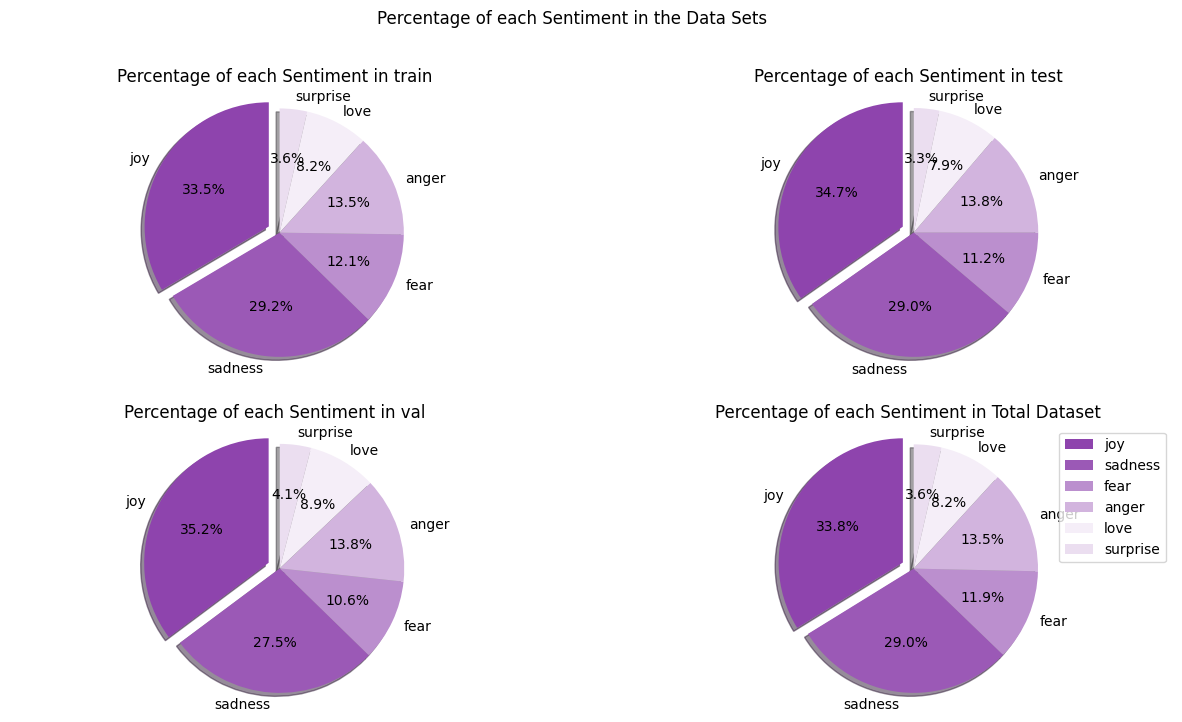

In [8]:
def pie_chart(data_frames):
    combin = ["train", "test", "val"]
    fig, ax = plt.subplots(2, 2, figsize=(15, 8))

    colors = ['#8E44AD', '#9B59B6', '#BB8FCE', '#D2B4DE', '#F5EEF8', '#EBDEF0']

    for i, dataset in enumerate(combin):
        labels = "joy", "sadness", "fear", "anger", "love", "surprise"
        sizes = [data_frames[dataset]['Sentiment'].value_counts()[i] for i in labels]
        explode = (0.1, 0, 0, 0, 0, 0) 
        row = i // 2
        col = i % 2
        ax[row, col].pie(
            sizes,
            explode=explode,
            labels=labels,
            autopct="%1.1f%%",
            shadow=True,
            startangle=90,
            colors=colors
        )
        ax[row, col].set_title(f"Percentage of each Sentiment in {dataset}")
        ax[row, col].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Adding the fourth pie chart for the total dataset
    labels = "joy", "sadness", "fear", "anger", "love", "surprise"
    sizes = [sum([data_frames[dataset]['Sentiment'].value_counts()[i] for dataset in combin]) for i in labels]
    explode = (0.1, 0, 0, 0, 0, 0)
    ax[1, 1].pie(
        sizes,
        explode=explode,
        labels=labels,
        autopct="%1.1f%%",
        shadow=True,
        startangle=90,
        colors=colors
    )
    ax[1, 1].set_title("Percentage of each Sentiment in Total Dataset")
    ax[1, 1].axis("equal")

    plt.suptitle("Percentage of each Sentiment in the Data Sets")
    plt.legend()
    plt.show()

pie_chart(data_frames)

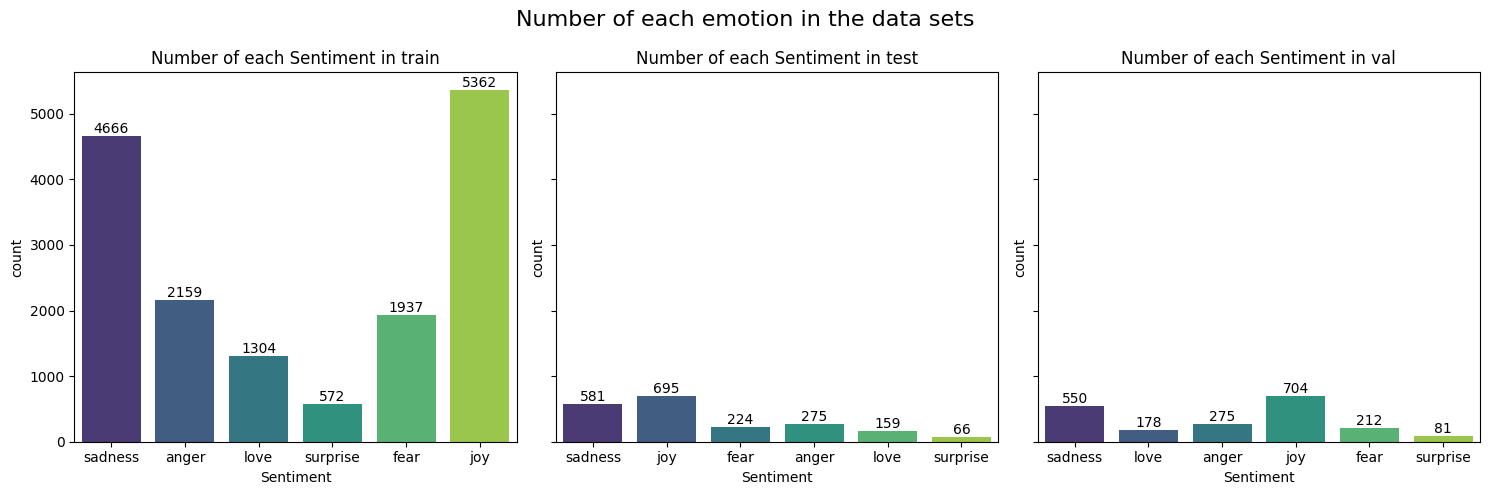

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def bar_chart(data_frames):
    datasets = ["train", "test", "val"]
    num_datasets = len(datasets)
    fig, ax = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5), sharey=True)
    palette = sns.color_palette("viridis", 6)

    for i, dataset in enumerate(datasets):
        sns.countplot(data=data_frames[dataset], x="Sentiment", palette=palette, ax=ax[i])
        ax[i].set_title(f"Number of each Sentiment in {dataset}")

        # Display number of each emotion above the bars
        for p in ax[i].patches:
            ax[i].annotate(
                f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, 5),
                textcoords="offset points",
            )

    fig.suptitle("Number of each emotion in the data sets", fontsize=16)
    plt.tight_layout()
    plt.show()

bar_chart(data_frames)

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 15px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#56008c; overflow:hidden"><b> Data Processing  </b></div>

 

<div style="padding: 20px; border-color: #c77220; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid purple;">
    <p>Next code is used in natural language processing (NLP) tasks to clean and preprocess text data by removing words that are not useful for analysis or modeling.</p>
  <p>Natural Language Toolkit (nltk) allows to download a list of common English stopwords</p>
    <ol>
        <li><strong>Downloading Stopwords:</strong> The <code>nltk.download('stopwords')</code> command downloads the stopwords dataset. Stopwords are common words like "and", "the", "is", etc., which are usually filtered out during text processing because they don't carry significant meaning.</li>
        <li><strong>Printing Stopwords:</strong> The <code>print(stopwords.words('english'))</code> command prints the list of English stopwords. This list can be used in text preprocessing steps to remove these common words from text data, helping to focus on the more meaningful words.</li>
    </ol>
</div>
    

In [10]:
nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any'

<div style="padding: 20px; border-color: #c77220; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid purple;">
 <p>This code defines a custom transformer <code>TextProcessor</code> for text preprocessing, suitable for use in a machine learning pipeline with scikit-learn. The class has two optional parameters, <code>lower</code> and <code>stem</code>, which when set to <code>True</code>, convert text to lowercase and apply stemming, respectively. The <code>transform</code> method processes each input text by removing non-alphabet characters, optionally converting to lowercase, splitting into words, removing stopwords, and applying stemming if specified. This preprocessed text is then returned for each input text.</p>
</div>
    

In [11]:
class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=False, stem=False):
        self.lower = lower
        self.stem = stem
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def text_processing(text):
            processed_text = re.sub('[^a-zA-Z]', ' ', text) # this code removes any non-alphabet characters
            if self.lower:
                processed_text = processed_text.lower()
            processed_text = processed_text.split()
            if self.stem:
                ps = PorterStemmer()
                processed_text = [ps.stem(word) for word in processed_text if word not in set(stopwords.words('english'))]
            processed_text = ' '.join(processed_text)
            return processed_text
        
        return [text_processing(text) for text in X]

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 15px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#56008c; overflow:hidden"><b> Model Building  </b></div>


<div style="text-align: center;">
    <img src="https://i.gifer.com/3ai3.gif" alt="alzheimers" style="width:100%; height:auto; border-radius: 30px;">
</div>

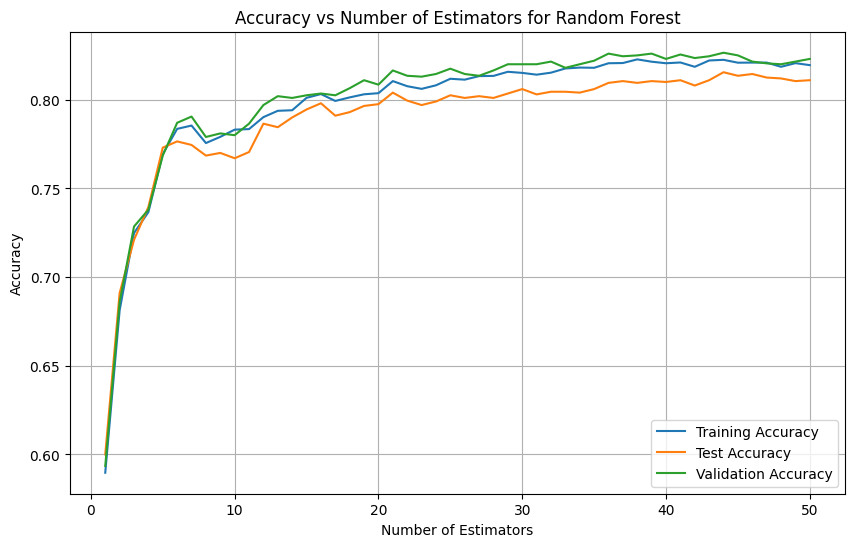

In [12]:
# Next code suppresses the parallel processing messages
logging.getLogger('joblib').setLevel(logging.ERROR)

text_processor = TextProcessor(lower=True, stem=False)
vectorizer = CountVectorizer(max_features=3000)
RF = RandomForestClassifier(
    n_estimators=50, random_state=42, n_jobs=-1, verbose=0,  # Set verbose to 0 to suppress messages
    max_depth=100, min_samples_split=100, min_samples_leaf=5, max_features='sqrt'
)

pipeline = Pipeline([
    ("text_processing", text_processor),  
    ("vectorizer", vectorizer),          
    ("classifier", RF)                    
])


pipeline.fit(train_dataset['Text'], train_dataset['Sentiment'])

train_accuracies = []
test_accuracies = []
val_accuracies = []

for i in range(1, 51):
    RF.set_params(n_estimators=i)
    pipeline.fit(train_dataset['Text'], train_dataset['Sentiment'])
    
    # Accuracy for training set
    train_pred = pipeline.predict(train_dataset['Text'])
    train_accuracy = accuracy_score(train_dataset['Sentiment'], train_pred)
    train_accuracies.append(train_accuracy)
   
    
    # Accuracy for test set
    test_pred = pipeline.predict(test_dataset['Text'])
    test_accuracy = accuracy_score(test_dataset['Sentiment'], test_pred)
    test_accuracies.append(test_accuracy)
   
    
    # Accuracy for validation set
    val_pred = pipeline.predict(validation_dataset['Text'])
    val_accuracy = accuracy_score(validation_dataset['Sentiment'], val_pred)
    val_accuracies.append(val_accuracy)
 

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 51), test_accuracies, label='Test Accuracy')
plt.plot(range(1, 51), val_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 15px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#56008c; overflow:hidden"><b> Model Evaluation  </b></div>

In [13]:

print("Train set accuracy:", train_accuracy)

print("Test set accuracy:", test_accuracy)

print("Validation set accuracy:", val_accuracy)

Train set accuracy: 0.8195
Test set accuracy: 0.811
Validation set accuracy: 0.823


In [14]:
def plot_confusion_matrices_and_classification_report(train_true, train_pred, val_true, val_pred, test_true, test_pred, labels):
    train_conf_matrix = confusion_matrix(train_true, train_pred)
    val_conf_matrix = confusion_matrix(val_true, val_pred)
    test_conf_matrix = confusion_matrix(test_true, test_pred)

    print("Train Classification Report:\n", classification_report(train_true, train_pred, target_names=labels))
    print("Validation Classification Report:\n", classification_report(val_true, val_pred, target_names=labels))
    print("Test Classification Report:\n", classification_report(test_true, test_pred, target_names=labels))

    fig, axes = plt.subplots(3, 1, figsize=(8, 18))

    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Purples', 
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title('Train Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Purples', 
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title('Validation Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Purples', 
                xticklabels=labels, yticklabels=labels, ax=axes[2])
    axes[2].set_title('Test Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')

    plt.tight_layout()
    plt.show()

Train Classification Report:
               precision    recall  f1-score   support

       anger       0.90      0.76      0.82      2159
        fear       0.82      0.80      0.81      1937
         joy       0.72      0.96      0.82      5362
        love       0.90      0.61      0.73      1304
     sadness       0.94      0.78      0.85      4666
    surprise       0.91      0.62      0.73       572

    accuracy                           0.82     16000
   macro avg       0.86      0.75      0.79     16000
weighted avg       0.84      0.82      0.82     16000

Validation Classification Report:
               precision    recall  f1-score   support

       anger       0.90      0.76      0.83       275
        fear       0.81      0.80      0.80       224
         joy       0.72      0.95      0.82       695
        love       0.84      0.57      0.68       159
     sadness       0.95      0.77      0.85       581
    surprise       0.75      0.50      0.60        66

    accuracy

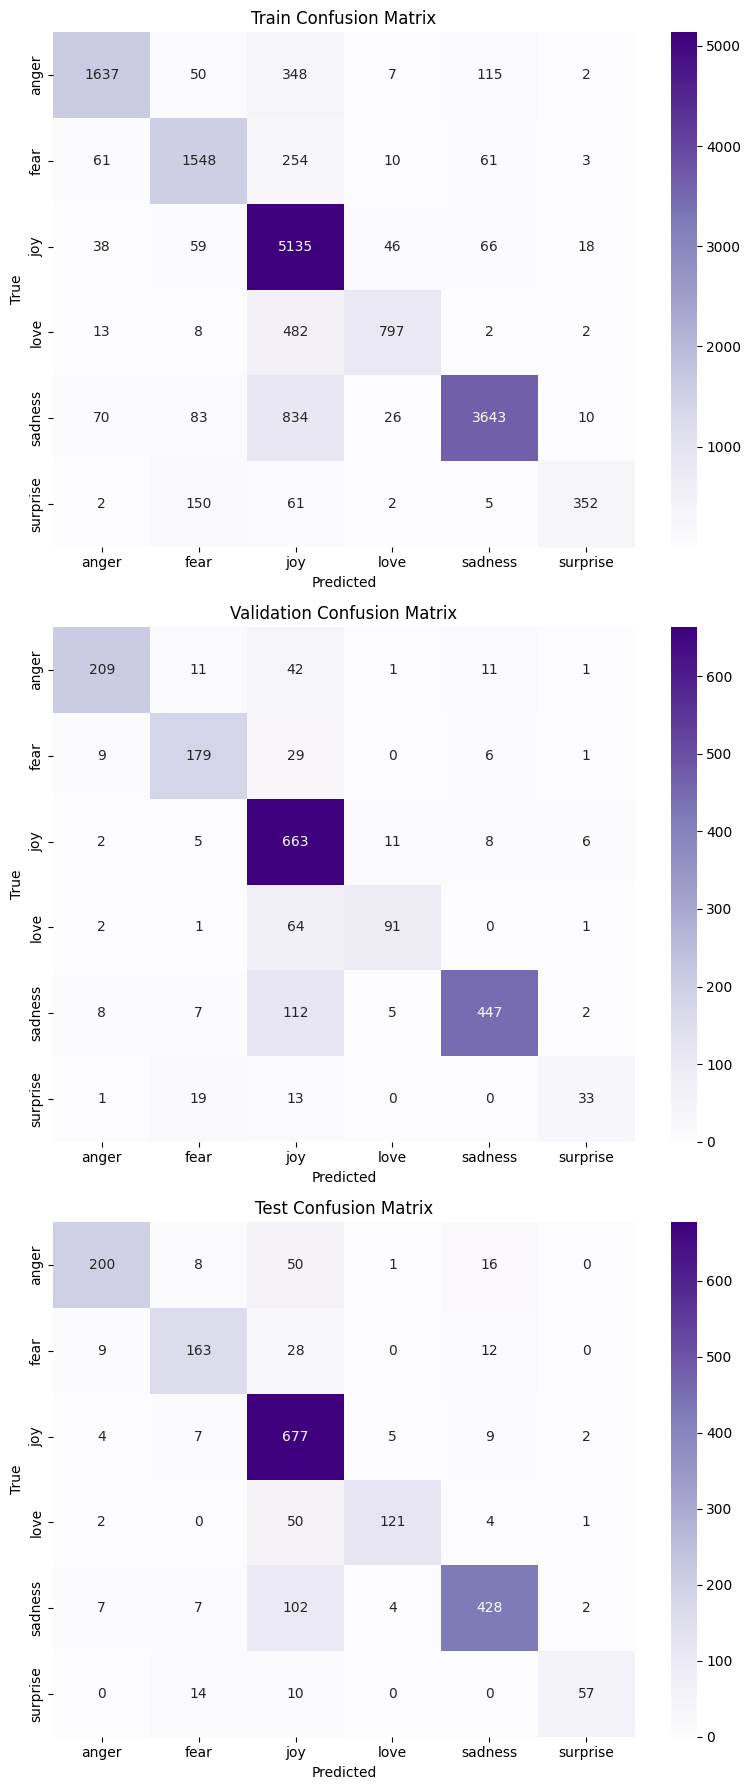

In [15]:
plot_confusion_matrices_and_classification_report(
    train_dataset['Sentiment'], train_pred,
    test_dataset['Sentiment'], test_pred,
    validation_dataset['Sentiment'], val_pred,
    pipeline.classes_
)

<a id="A"></a>
# <div style="text-align:center; border-radius:15px 15px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#56008c; overflow:hidden"><b> Conclusion  </b></div>

<div style="padding: 20px; border-color: #c77220; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid purple;">
     <ul style="font-size: 16px; font-family: 'Arial'; line-height: 1.5em;">
        <li>In conclusion, the model demonstrates that it is not overfitting as the accuracy for training, validation, and test datasets all have similar values, exceeding 80%. This indicates that the model generalizes well to new data. Through this project, a sentiment analysis was successfully developed using NLP and the Random Forest Classifier, proving its capability to accurately predict emotions from text and perform effectively on unseen data.</li>
    </ul>
</div>

# **Thank you for participating** 

If you found this notebook helpful, please consider upvoting it. Your positive feedback helps us to continue providing valuable content and assists others in discovering useful resources. 

Your support is greatly appreciated 💜!


<div style="text-align: center;">
    <img src="https://gifdb.com/images/high/joy-inside-out-jumping-up-and-down-2u6lt8ji7nwhoiyj.gif" alt="alzheimers" style="width:100%; height:auto; border-radius: 30px;">
</div>